In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')
import pandas as pd

/tmp/ipykernel_563801/2817862154.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [9]:

def postprocess_df(series, exclude_keys=None):
    """
    Takes a pandas Series with a MultiIndex and folds over all keys except for those specified
    in `exclude_keys` by concatenating the key name and its value into the 'algo' column values.

    Parameters:
    - series: pandas.Series with a MultiIndex.
    - exclude_keys: list of strings representing keys to exclude from the folding process.

    Returns:
    - A DataFrame with 'algo' and 'dataset' columns, where 'algo' has been modified to include
      information from other keys.
    """

    if exclude_keys is None:
      exclude_keys=['algo', 'dataset', 'final_acc']
    # Convert the Series into a DataFrame
    df = series.reset_index()
    
    # # Initialize a column to store the modified algo values
    df['modified_algo'] = df['algo']
    exclude_keys += ['modified_algo']
    
    # # Iterate over each level of the original MultiIndex (now columns in df)
    for key in df.columns:
        if key not in exclude_keys:
            # Append the key name and its value to the 'modified_algo' entries
            df['modified_algo'] = df['modified_algo'] + '_' + key + ':' + df[key].astype(str)
    
    # # Select and rename the relevant columns for the final DataFrame
    final_df = df[['modified_algo', 'dataset', series.name]].copy()
    final_df.rename(columns={'modified_algo': 'algo', series.name: 'value'}, inplace=True)
    
    return final_df

def aggregate_results(df, keys=None, metric=None, post_process=True):
   if keys is None:
      keys = ["algo", "use_contrastive"]
   if metric is None:
      metric = "final_acc"
   keys += ["dataset"]
   m = df.groupby(keys)[
         metric].mean()
   stderr = df.groupby(keys)[metric].sem()
   if post_process:
      exclude_keys=["algo", "dataset", metric]
      m = postprocess_df(m, exclude_keys)
      stderr = postprocess_df(stderr, exclude_keys)
   return m, stderr

                  
   
                   
def plot_bar_res(df, color_map=None, edgecolor_map=None, bar_width=0.2, keys=None,
      metric=None,
      remap_name=None,
      hatch_map=None,):
    """
    Corrected plotting function that properly handles DataFrame structures.
    """
    m, stderr = aggregate_results(df, keys=keys, metric=metric)

    # Extract unique datasets and algorithms for plotting
    datasets = sorted(m['dataset'].unique())[::-1]
    algos = sorted(m['algo'].unique())[::-1]

    # Set figure size and plot properties
    fig, ax = plt.subplots(figsize=(10, 4))
    opacity = 0.8
    linewidth = 2


    print(m)
    for i, algo in enumerate(algos):
        positions = np.arange(len(datasets)) + i * bar_width
        # Filter rows for the current algorithm
        algo_means = m[m['algo'] == algo].set_index('dataset')['value'].reindex(datasets).values
        algo_stderr = stderr[stderr['algo'] == algo].set_index('dataset')['value'].reindex(datasets).values

        ax.bar(positions, algo_means, bar_width, yerr=algo_stderr, alpha=opacity, label=remap_name[algo] if remap_name is not None else algo,
               linewidth=linewidth,
               color=color_map[algo] if color_map is not None else None, edgecolor=edgecolor_map[algo] if edgecolor_map is not None else None,
               hatch=hatch_map[algo] if hatch_map is not None else None)

    # Set x-axis labels, titles, and legend
    ax.set_xticks(np.arange(len(datasets)) + bar_width * (len(algos) - 1) / 2)
    ax.set_xticklabels(datasets, fontsize=12)
    ax.set_ylim([0.5, 1])
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_xlabel('Dataset', fontsize=14)
    ax.set_title('Comparison of Algorithm Performance', fontsize=16, fontweight='bold')
    ax.legend(frameon=True, loc='lower right', bbox_to_anchor=(1.28, 0.0))
    ax.grid(True, which='major', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig("Figures/results.pdf", bbox_inches="tight")


In [10]:
color_map = {
   'modular_use_contrastive:False': '#3182bd',
   'monolithic_use_contrastive:False': '#de2d26',
   'modular_modmod_use_contrastive:False':  '#214073',  # Corrected key
   'modular_fedavg_use_contrastive:False': '#6a9bbd',  # Changed key format
   'monolithic_fedavg_use_contrastive:False': '#a50f15',  # Changed key format
   'modular_recv_use_contrastive:False': '#08519c',  # Changed key format
   'monolithic_recv_use_contrastive:False': '#cb181d',  # Changed key format
}

edgecolor_map = {
   'modular_use_contrastive:False': '#214073',
   'monolithic_use_contrastive:False': '#a6221f',
   'modular_modmod_use_contrastive:False':  '#08306b',  # Corrected key
   'modular_fedavg_use_contrastive:False': '#4292c6',  # Changed key format
   'monolithic_fedavg_use_contrastive:False': '#67000d',  # Changed key format
   'modular_recv_use_contrastive:False': '#04386a',  # Changed key format
   'monolithic_recv_use_contrastive:False': '#b2171d',  # Changed key format
}

remap_name = {
   'modular_use_contrastive:False': 'Mod',
   'monolithic_use_contrastive:False': 'Mono',
   'modular_modmod_use_contrastive:False':  'Mod mod',  # Corrected key
   'modular_fedavg_use_contrastive:False': 'Mod fedavg',  # Changed key format
   'monolithic_fedavg_use_contrastive:False': 'Mono fedavg',  # Changed key format
   'modular_recv_use_contrastive:False': 'Mod recv',  # Changed key format
   'monolithic_recv_use_contrastive:False': 'Mono recv',  # Changed key format
}

hatch_map = {
   'modular_use_contrastive:False': '',
   'monolithic_use_contrastive:False': '',
   'modular_modmod_use_contrastive:False':  '/',  # Corrected key
   'modular_fedavg_use_contrastive:False': '.',  # Changed key format
   'monolithic_fedavg_use_contrastive:False': '.',  # Changed key format
   'modular_recv_use_contrastive:False': '+',  # Changed key format
   'monolithic_recv_use_contrastive:False': '+',  # Changed key format
}

In [11]:
vanilla_df = pd.read_csv('experiment_results/vanilla_jorge_setting_basis_no_sparse.csv')
modmod_df = pd.read_csv('experiment_results/jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True.csv')
fed_df = pd.read_csv('experiment_results/jorge_setting_fedavg.csv')
recv_df = pd.read_csv('experiment_results/jorge_setting_recv.csv')

In [12]:
# filter vanilla_df to only include `use_contrastive` = False
vanilla_df = vanilla_df[vanilla_df['use_contrastive'] == False]
modmod_df = modmod_df[modmod_df['use_contrastive'] == False]
fed_df = fed_df[fed_df['use_contrastive'] == False]
recv_df = recv_df[recv_df['use_contrastive'] == False]

In [13]:
# # # add fedavg to the algo column of fed_df
# fed_df['algo'] = 'fedavg_' + fed_df['algo']
# modmod_df['algo'] = 'modmod_' + modmod_df['algo']
# recv_df['algo'] = 'recv_' + recv_df['algo']


fed_df['algo'] = fed_df['algo'] + '_fedavg'
modmod_df['algo'] = modmod_df['algo'] + '_modmod'
recv_df['algo'] = recv_df['algo'] + '_recv'

In [14]:
df = pd.concat([vanilla_df, modmod_df, fed_df, recv_df])

                                       algo       dataset     value
0             modular_use_contrastive:False      cifar100  0.715984
1             modular_use_contrastive:False  fashionmnist  0.928013
2             modular_use_contrastive:False        kmnist  0.806317
3             modular_use_contrastive:False         mnist  0.934668
4      modular_fedavg_use_contrastive:False  fashionmnist  0.924572
5      modular_fedavg_use_contrastive:False        kmnist  0.800375
6      modular_fedavg_use_contrastive:False         mnist  0.935689
7      modular_modmod_use_contrastive:False      cifar100  0.722527
8      modular_modmod_use_contrastive:False  fashionmnist  0.932812
9      modular_modmod_use_contrastive:False        kmnist  0.818337
10     modular_modmod_use_contrastive:False         mnist  0.940794
11       modular_recv_use_contrastive:False  fashionmnist  0.935573
12       modular_recv_use_contrastive:False        kmnist  0.825946
13       modular_recv_use_contrastive:False     

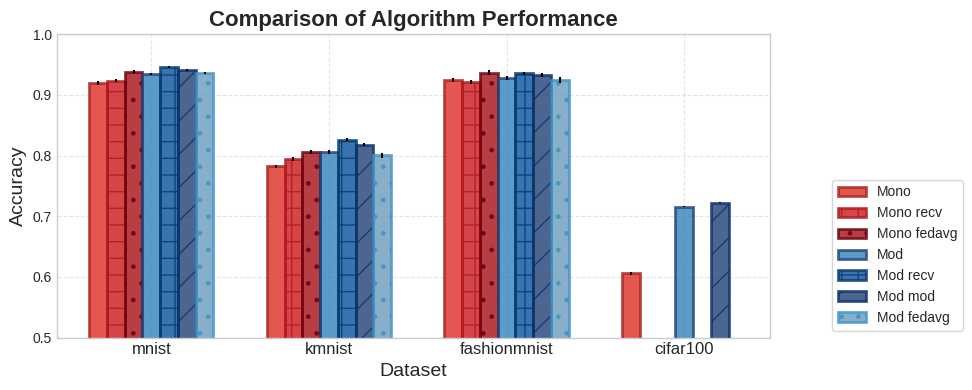

In [15]:
# plot_bar_res(vanilla_df, color_map=color_map, edgecolor_map=edgecolor_map)
plot_bar_res(df, bar_width=0.1, color_map=color_map, edgecolor_map=edgecolor_map,
remap_name=remap_name, hatch_map=hatch_map, metric='final_acc')

In [16]:
m , stderr = aggregate_results(df)
m

,algo,dataset,value
0,modular_use_contrastive:False,cifar100,0.715984
1,modular_use_contrastive:False,fashionmnist,0.928013
2,modular_use_contrastive:False,kmnist,0.806317
3,modular_use_contrastive:False,mnist,0.934668
4,modular_fedavg_use_contrastive:False,fashionmnist,0.924572
5,modular_fedavg_use_contrastive:False,kmnist,0.800375
6,modular_fedavg_use_contrastive:False,mnist,0.935689
7,modular_modmod_use_contrastive:False,cifar100,0.722527
8,modular_modmod_use_contrastive:False,fashionmnist,0.932812
9,modular_modmod_use_contrastive:False,kmnist,0.818337


In [18]:
def format_df_for_table(m):
    res = m.copy()
    # Remove the "_use_contrastive:False" part for cleaner extraction
    res['algo_clean'] = res['algo'].str.replace('_use_contrastive:False', '')

    # Now, extract 'base' and 'algorithm' accurately
    res['base'] = res['algo_clean'].str.extract(r'^([^_]+)')[0]
    res['algorithm'] = res['algo_clean'].str.extract(r'_(.+)$')[0]

    # Fill NaN in 'algorithm' with 'vanilla'
    res['algorithm'].fillna('vanilla', inplace=True)

    # Drop the columns we don't need anymore
    res.drop(['algo', 'algo_clean'], axis=1, inplace=True)

    res = res.pivot_table(index=['base', 'algorithm'], columns='dataset', values='value', aggfunc='first').reset_index()
    return res

In [19]:
from prettytable import PrettyTable


# Prepare the PrettyTable

def make_table(pivot_m):
    table = PrettyTable()
    columns = ['Base', 'Algorithm'] + [col for col in pivot_m.columns if col not in ('base', 'algorithm')]
    table.field_names = columns

    max_values = pivot_m.max()


    for _, row in pivot_m.iterrows():
        row_data = []
        for col in pivot_m.columns:
            if col not in ('base', 'algorithm') and not pd.isna(row[col]):
                # Bold the highest value for each dataset
                if row[col] == max_values[col]:
                    row_data.append(f"**{row[col]:.5f}**")
                else:
                    row_data.append(f"{row[col]:.5f}")
            else:
                row_data.append(row[col])
        table.add_row(row_data)
    return table

In [20]:
pivot_m = format_df_for_table(m)
table = make_table(pivot_m)
print(table)

+------------+-----------+-------------+--------------+-------------+-------------+
|    Base    | Algorithm |   cifar100  | fashionmnist |    kmnist   |    mnist    |
+------------+-----------+-------------+--------------+-------------+-------------+
|  modular   |   fedavg  |     nan     |   0.92457    |   0.80038   |   0.93569   |
|  modular   |   modmod  | **0.72253** |   0.93281    |   0.81834   |   0.94079   |
|  modular   |    recv   |     nan     |   0.93557    | **0.82595** | **0.94595** |
|  modular   |  vanilla  |   0.71598   |   0.92801    |   0.80632   |   0.93467   |
| monolithic |   fedavg  |     nan     | **0.93676**  |   0.80553   |   0.93864   |
| monolithic |    recv   |     nan     |   0.92100    |   0.79469   |   0.92351   |
| monolithic |  vanilla  |   0.60579   |   0.92467    |   0.78227   |   0.91959   |
+------------+-----------+-------------+--------------+-------------+-------------+
